In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation,BatchNormalization,Lambda,Input,Conv2D,Bidirectional,LSTM, Concatenate, MaxPooling2D,GlobalAveragePooling2D
import tensorflow.keras.backend as K
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from time import time
import datetime
import numpy as np

In [3]:

def convert_to_onehot(data):
    #Creates a dict, that maps to every char of alphabet an unique int based on position
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789"
    char_to_int = dict((c,i) for i,c in enumerate(alphabet))
    
    encoded_data = []
    #Replaces every char in data with the mapped int
    encoded_data.append([char_to_int[char] for char in data])
    
    

    #This part now replaces the int by an one-hot array with size alphabet
    one_hot = []
    for value in encoded_data:
        #At first, the whole array is initialized with 0
        
        for indexvalue in value:
            letter = [0 for _ in range(len(alphabet))]
            #Only at the number of the int, 1 is written

            letter[indexvalue] = 1
            
            one_hot.append(letter)
    return one_hot

def convert_to_lable(data):
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789"
    return list(map(lambda x: alphabet.index(x), data))



convert_to_lable('abcd453')


[0, 1, 2, 3, 30, 31, 29]

[19, 4, 23, 19]

In [113]:

def crnn():
    x=image_input=Input(name='image_input',shape=[150,150,3])
    """
    minx=Input(name='minx',shape=[1],dtype='float32')
    miny=Input(name='miny',shape=[1],dtype='float32')
    maxx=Input(name='maxx',shape=[1],dtype='float32')
    maxy=Input(name='maxy',shape=[1],dtype='float32')
    def cropimage(img,minx=0,miny=0,maxx=0,maxy=0):
        
        return tf.image.crop_to_bounding_box(img,minx,miny,maxx-minx,maxy-miny)
    x=Lambda(cropimage)([x,minx,miny,maxx,maxy])
    
    """
        
    x=Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1_1')(x)
    x=MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1', padding='same')(x)
    
    x=Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2_1')(x)
    x=MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2', padding='same')(x)

    x=Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3_1')(x)
    x=Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3_2')(x)
    x=MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3', padding='same')(x)
    
    x=Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4_1')(x)
    x=BatchNormalization(name='batch1')(x)
    
    x=Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv5_1')(x)
    x=BatchNormalization(name='batch2')(x)
    x=MaxPooling2D(pool_size=(2, 2), strides=(1, 2), name='pool5', padding='valid')(x)
    
    x=Conv2D(512, (2, 2), strides=(1, 1), activation='relu', padding='valid', name='conv6_1')(x)
    x=keras.layers.Reshape((-1,512))(x)
    
    x=Bidirectional(LSTM(256, return_sequences=True))(x)
    x=Bidirectional(LSTM(256, return_sequences=True))(x)
    num_classes=36
    x=keras.layers.Dense(num_classes, name='dense1')(x)#알파벳+숫자
    
    x=y_pred= Activation('softmax', name='softmax')(x)
    
   # model_pred=keras.models.Model(inputs=[image_input,minx,miny,maxx,maxy],outputs=x)
    model_pred=keras.models.Model(inputs=image_input,outputs=x)
    
    maxstringlen=int(y_pred.shape[1])
    
    def ctc_lambda_func(args):
        labels, y_pred, input_length, label_length = args
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)    
    
    labels = Input(name='label_input', shape=[maxstringlen], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64') 
    
    ctcloss=Lambda(ctc_lambda_func,output_shape=(1,),name='ctc')([labels,y_pred,input_length,label_length])
    
   # model_train=keras.models.Model(inputs=[image_input,minx,miny,maxx,maxy,labels,input_length,label_length],outputs=ctc_loss)
    model_train=keras.models.Model(inputs=[image_input,labels,input_length,label_length],outputs=ctcloss)
    
    return model_train,model_pred,maxstringlen

    

In [114]:
traincrnn,predcrnn,inputlength=crnn()

In [4]:
cropvalpath='D:/ocr/cropvalimage/'
#croptrainpath='D:/ocr/croptrainimage/'
valdf=pd.read_json('valcrnn.json',orient='index')
valdf['label']=valdf['label'].apply(lambda x: convert_to_lable(x))
traindf=pd.read_json('traincrnn.json',orient='index')
traindf['label']=traindf['label'].apply(lambda x: convert_to_lable(x))

In [16]:
valdf.loc[valdf['cropimgid']=='a7ad2bcb93d48576_2']['label']

a7ad2bcb93d48576_2    [12, 14, 17, 6, 0, 13]
Name: label, dtype: object

In [11]:
valdf

,cropimgid,label,imgid,labellangth
a7ad2bcb93d48576_1,a7ad2bcb93d48576_1,"[17, 8, 2, 7, 0, 17, 3]",a7ad2bcb93d48576,7
a7ad2bcb93d48576_2,a7ad2bcb93d48576_2,"[12, 14, 17, 6, 0, 13]",a7ad2bcb93d48576,6
a7ad2bcb93d48576_3,a7ad2bcb93d48576_3,"[0, 11, 19, 4, 17, 4, 3]",a7ad2bcb93d48576,7
a7ad2bcb93d48576_4,a7ad2bcb93d48576_4,"[2, 0, 17, 1, 14, 13]",a7ad2bcb93d48576,6
a7ad2bcb93d48576_5,a7ad2bcb93d48576_5,"[0, 13]",a7ad2bcb93d48576,2
...,...,...,...,...
607b023cd68febab_52,607b023cd68febab_52,"[1, 14, 23, 4, 18]",607b023cd68febab,5
607b023cd68febab_53,607b023cd68febab_53,"[13, 4, 22]",607b023cd68febab,3
607b023cd68febab_55,607b023cd68febab_55,"[18, 19, 14, 13, 4, 18]",607b023cd68febab,6
607b023cd68febab_61,607b023cd68febab_61,[12],607b023cd68febab,1


In [116]:
trainlabel=traindf['label']
vallabel=valdf['label']
trainlabellength=traindf['labellangth']#a-e 스펠링틀림
vallabellength=valdf['labellangth']
trainlabel=trainlabel.reset_index()
trainlabel=trainlabel['label']
#vallabel= vallabel.sort_index()
vallabel=vallabel.reset_index()
#vallabel=vallabel['label']
trainlabellength=trainlabellength.reset_index()
trainlabellength=trainlabellength['labellangth']
vallabellength=vallabellength.reset_index()
vallabellength=vallabellength['labellangth']
inputlengthlist=np.full(len(vallabel),inputlength)

In [117]:
vallabel['index']=vallabel['index'].apply(lambda x:cropvalpath+x+'.jpg')

In [118]:
"""
traindata=tf.keras.preprocessing.image_dataset_from_directory(
    croptrainpath,
    labels=None,
    label_mode=None,
    image_size=(150,150),
    smart_resize=True
)

valdata=tf.keras.preprocessing.image_dataset_from_directory(
    cropvalpath,
    #labels=list(vallabel),
   # label_mode='categorical',
    image_size=(150,150),
    smart_resize=True,
    #validation_split=0.2,
    #subset='training',
    seed=111,
    batch_size=16
    
)
"""
valdatagen=tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
valdata=valdatagen.flow_from_dataframe(vallabel,
                               x_col='index',
                               y_col='label',
                               target_size=(150,150),
                               color_mode='rgb',
                               batch_size=16,
                               interpolation='nearest',
                               class_mode='raw'
                               
                              
                              )
#flowfromdataframe


Found 105729 validated image filenames.


[array([8, 5]) array([19,  9,  7, 13, 21]) array([4, 9, 5])
 array([ 9, 20]) array([20,  8,  1, 20]) array([13,  5, 20,  1, 12, 19])
 array([36, 36,  3]) array([22,  9,  3, 20, 15, 18,  9,  1]) array([30])
 array([ 1, 14, 20,  8, 15, 14, 25]) array([ 7, 18,  5,  5, 14])
 array([12, 15,  1,  4,  9, 14,  7]) array([15, 15, 19, 20])
 array([20,  8,  5]) array([19, 20, 15, 16]) array([ 1, 14,  4])]


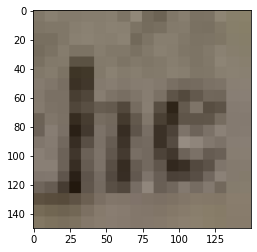

In [121]:

for images,i in valdata:
  
    print(i)
    plt.imshow(images[0].astype(np.uint8))
    break;
    plt.axis("off")

In [122]:
valdata.labels

array([array([18,  9,  3,  8,  1, 18,  4]),
       array([13, 15, 18,  7,  1, 14]),
       array([ 1, 12, 20,  5, 18,  5,  4]), ...,
       array([19, 20, 15, 14,  5, 19]), array([13]), array([13])],
      dtype=object)

In [123]:
vallabellength=[]
for i in valdata.labels:
    vallabellength.append(len(i))
vallabellength

[7,
 6,
 7,
 6,
 2,
 11,
 5,
 2,
 4,
 1,
 9,
 2,
 4,
 5,
 1,
 8,
 7,
 6,
 6,
 6,
 3,
 11,
 3,
 5,
 4,
 3,
 6,
 2,
 7,
 6,
 7,
 6,
 5,
 6,
 1,
 7,
 6,
 5,
 3,
 3,
 4,
 2,
 6,
 1,
 8,
 2,
 3,
 6,
 4,
 9,
 12,
 3,
 5,
 9,
 2,
 4,
 4,
 9,
 3,
 5,
 6,
 4,
 9,
 11,
 2,
 2,
 4,
 9,
 3,
 5,
 2,
 4,
 3,
 11,
 5,
 2,
 3,
 7,
 2,
 4,
 4,
 9,
 3,
 9,
 2,
 4,
 1,
 4,
 9,
 3,
 7,
 6,
 12,
 7,
 4,
 3,
 8,
 10,
 2,
 3,
 2,
 8,
 9,
 13,
 4,
 5,
 8,
 4,
 8,
 7,
 5,
 2,
 6,
 3,
 6,
 2,
 5,
 6,
 1,
 4,
 2,
 5,
 1,
 2,
 2,
 1,
 7,
 3,
 7,
 2,
 1,
 4,
 2,
 3,
 4,
 8,
 7,
 11,
 4,
 2,
 3,
 9,
 9,
 2,
 3,
 8,
 3,
 4,
 4,
 4,
 3,
 3,
 5,
 6,
 1,
 3,
 9,
 6,
 3,
 3,
 3,
 3,
 4,
 5,
 10,
 3,
 11,
 2,
 4,
 3,
 8,
 4,
 6,
 9,
 7,
 8,
 2,
 5,
 3,
 7,
 5,
 6,
 3,
 3,
 4,
 5,
 2,
 3,
 3,
 2,
 9,
 8,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 3,
 3,
 3,
 1,
 6,
 5,
 6,
 1,
 9,
 5,
 6,
 3,
 3,
 3,
 1,
 6,
 1,
 7,
 9,
 6,
 6,
 3,
 6,
 3,
 1,
 12,
 7,
 2,
 2,
 3,
 2,
 1,
 2,
 1,
 2,
 2,
 4,
 8,
 3,
 3,
 3,
 7,
 3,
 6,
 2,
 7,
 6,


In [124]:
traincrnn.compile(optimizer='adam',loss={'ctc':lambda labels,y_pred:y_pred})

In [125]:
from tensorflow.python.keras.callbacks import TensorBoard  ## TensorBoard 를 import합니다.
modelver='crnn_train_v1'
checkdir = './checkpoints/' + datetime.datetime.now().strftime('%Y%m%d%H%M') + '_' + modelver
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())
log_dir = "./logs/fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard =TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
def batch_generator(x, y, input_length,label_length,batchsize):
    sample_idx = 0
    while True:
        for row in range(batchsize):
            
        
    

In [126]:
#[image_input,labels,input_length,label_length]
his=traincrnn.fit(x=[valdata,valdata.labels,np.array( inputlengthlist),np.array(vallabellength)],
              y=valdata.labels,
                batch_size=16, 
              epochs=15,
              callbacks=[keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
                         tensorboard]
             )

his=traincrnn.fit_generator(valdata)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.keras.preprocessing.image.DataFrameIterator'>", "<class 'numpy.ndarray'>"}), <class 'numpy.ndarray'>

In [69]:
for i in valdata.take(1):
    testtake=i
    break
dsa=traincrnn.predict([testtake,[vallabel[1]],inputlength,len(vallabel)])
#dsa=traincrnn.predict([testtake,[1.,2.,3.,],inputlength,3])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {\'(<class \\\'list\\\'> containing values of types {"<class \\\'str\\\'>"})\'})', "<class 'int'>", "<class 'tensorflow.python.framework.ops.EagerTensor'>"}), <class 'NoneType'>

In [67]:
for i in valdata.take(1):
    print(i)
    break

tf.Tensor(
[[[[ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   ...
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]]

  [[ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   ...
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]]

  [[ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   [ 54.         53.         48.       ]
   ...
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]
   [ 78.        100.         28.       ]]

  ...

  [[ 30.         30.         42.       ]
   [ 30.         30.         42.       ]
   [ 30.         30.         42.       ]
   ...
   [ 63.         62.         42.       ]
   [ 63.         62.         42.       ]
   [ 

In [18]:
list(vallabel)[1]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
